June: Creating flux containers/planes and looking at scaling factors.

In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import xarray as xr
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles
import functions_upwelling_depth

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

from operator import itemgetter 

In [2]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

mesh = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/idealized/Resolution_237_177_80/Run01/mesh_mask.nc') 
gdepw_1d = mesh['gdepw_1d'][0,...]
gdepw_0 = mesh['gdepw_0'][0,...]
gdepu = mesh['gdepu'][0,...]
gdepv = mesh['gdepv'][0,...]
e3t_1d = mesh['e3t_1d'][0,...]
e3t_0 = mesh['e3t_0'][0,...]
e3w_1d = mesh['e3w_1d'][0,...]
e3w_0 = mesh['e3w_0'][0,...]
e3u_0 = mesh['e3u_0'][0,...]
e3v_0 = mesh['e3v_0'][0,...]
e1v = mesh['e1v'][0,...]
e1u = mesh['e1u'][0,...]
e2u = mesh['e2u'][0,...]
e1t = mesh['e1t'][0,...]
umask = mesh['umask'][0,...]
tmask = mesh['tmask'][0,...]
mbathy = mesh['mbathy'][0,...]

In [3]:
path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/Resolution_237_177_80/Run01/' 
gridU = xr.open_dataset(path + 'GYRE_1h_20170101_20170120_grid_U.nc')
gridV = xr.open_dataset(path + 'GYRE_1h_20170101_20170120_grid_V.nc')

In [42]:
U = gridU['vozocrtx'].values
U.shape

(480, 80, 177, 237)

In [47]:
umask0_rest = 1 - mesh['umask'][:]
umask_rest = np.tile(umask0_rest, (480, 1, 1, 1))
U_masked = np.ma.array(U, mask=umask_rest)

U_masked.shape

(480, 80, 177, 237)

# Scaling Factors

In [5]:
mesh

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    file_name: mesh_mask.nc
    TimeStamp: 22/06/2017 08:19:06 -0700
    dimensions(sizes): x(237), y(177), z(80), t(1)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 nav_lev(z), float64 time_counter(t), int8 tmask(t,z,y,x), int8 umask(t,z,y,x), int8 vmask(t,z,y,x), int8 fmask(t,z,y,x), int8 tmaskutil(t,y,x), int8 umaskutil(t,y,x), int8 vmaskutil(t,y,x), int8 fmaskutil(t,y,x), float32 glamt(t,y,x), float32 glamu(t,y,x), float32 glamv(t,y,x), float32 glamf(t,y,x), float32 gphit(t,y,x), float32 gphiu(t,y,x), float32 gphiv(t,y,x), float32 gphif(t,y,x), float64 e1t(t,y,x), float64 e1u(t,y,x), float64 e1v(t,y,x), float64 e1f(t,y,x), float64 e2t(t,y,x), float64 e2u(t,y,x), float64 e2v(t,y,x), float64 e2f(t,y,x), float64 ff(t,y,x), int16 mbathy(t,y,x), int16 misf(t,y,x), float32 isfdraft(t,y,x), float64 e3t_0(t,z,y,x), float64 e3u_0(t,z,y,x), float64 e3v_0(t,z,y,x), float64 e3

# Shelf Break Plane

In [6]:
# depth closest to the shelf depth
depth_shelf_approx = 80
ind_shelf = np.argmin(np.abs(gdepw_1d - depth_shelf_approx))
depth_shelf = gdepw_1d[ind_shelf]
ind_plane = np.argmin(np.abs(bathy[:,0] - depth_shelf))

# bathymetry of plane at the shelf break
bathy_plane = bathy[ind_plane,:]

<a list of 1 text.Text objects>

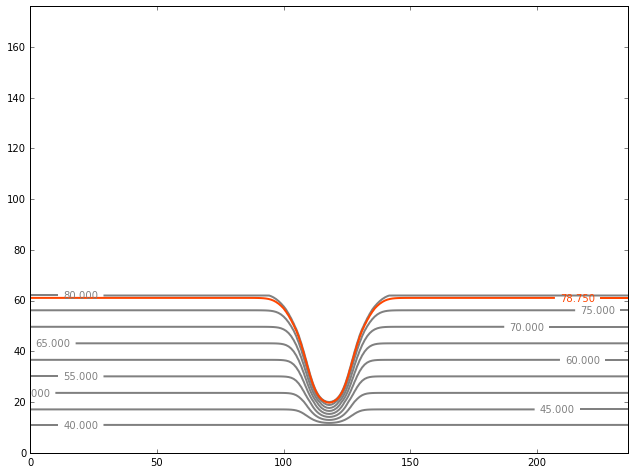

In [7]:
fig, ax = plt.subplots(1,1,figsize=(bathy.shape[1]/bathy.shape[0]*8, 8))
c = ax.contour(bathy[:,:], levels = np.arange(40,85,5), colors='gray', linewidths=2)
c1 = ax.contour(bathy[:,:], levels = [depth_shelf], colors='orangered', linewidths=2)
ax.clabel(c, inline=1, fontsize=10)
ax.clabel(c1, inline=1, fontsize=10)

# Vertical Planes

In [8]:
# depth closest to the bottom of the canyon
depth_canyon_approx = bathy_plane.max()
ind_canyon = np.argmin(np.abs(gdepw_1d - depth_canyon_approx))
depth_canyon = gdepw_1d[ind_canyon]

# canyon axis
ind_axis = np.where(bathy_plane == depth_canyon_approx)[0][0]

# finding the potential rim points
slope = abs(np.diff(bathy_plane))
ind_rimL0 = np.where(slope > 0.01)[0][0]
ind_rimR0 = np.where(slope > 0.01)[0][-1]

# index of the actual rim points
width_shelf = max(ind_rimR0 - ind_axis, ind_axis - ind_rimL0)
ind_rimL = ind_axis - width_shelf
ind_rimR = ind_axis + width_shelf

# adjacent containers with the same width
ind_shfL = ind_rimL - width_shelf
ind_shfR = ind_rimR + width_shelf

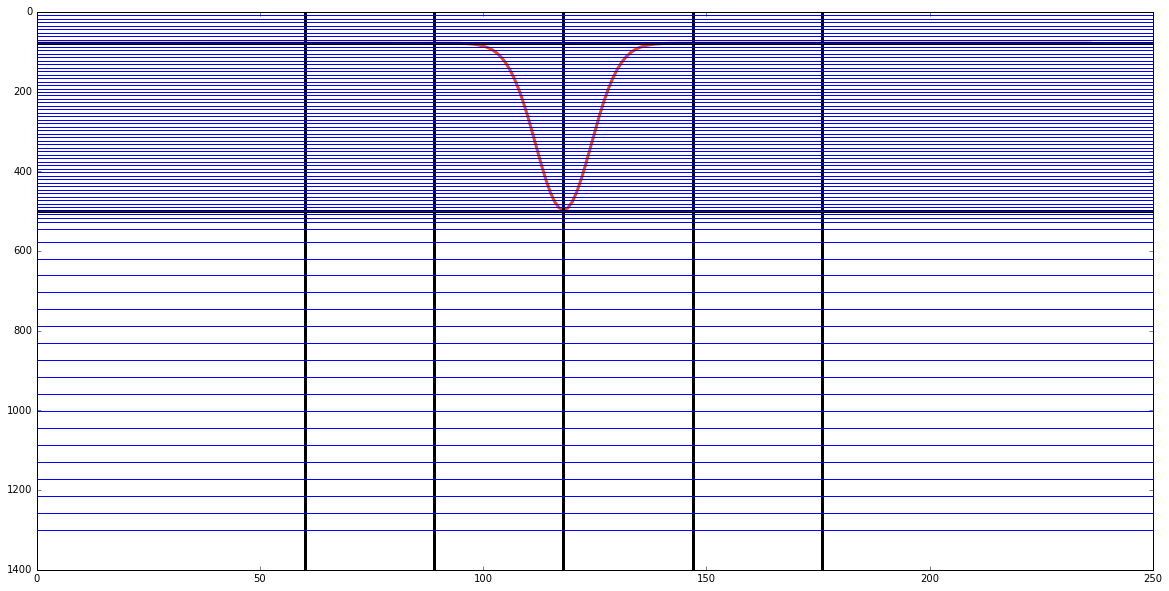

In [9]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(bathy_plane, lw=3, c='orangered')
ax.invert_yaxis()

lw, c = 3, 'k'

ax.axhline(depth_shelf, c=c, lw=lw)
ax.axhline(depth_canyon, c=c, lw=lw)

ax.axvline(ind_axis, c=c, lw=lw)
ax.axvline(ind_rimL, c=c, lw=lw)
ax.axvline(ind_rimR, c=c, lw=lw)
ax.axvline(ind_shfL, c=c, lw=lw)
ax.axvline(ind_shfR, c=c, lw=lw)

for gdepw in zip(gdepw_1d):
    ax.axhline(gdepw, c='b', label = 'gdepw')

# Areas for Flux

In [10]:
e1v.shape, e3v_0.shape, e2u.shape, e3u_0.shape

((177, 237), (80, 177, 237), (177, 237), (80, 177, 237))

In [11]:
mask_plane = tmask[:,ind_plane,:]

cell_x_j = e1v[ind_plane, :]
cell_y_j = e3v_0[:,ind_plane,:]
area_j = mask_plane * cell_x_j * cell_y_j

cell_x_i = e2u[ind_plane, :]
cell_y_i = e3u_0[:,ind_plane,:]
area_i = mask_plane * cell_x_i * cell_y_i

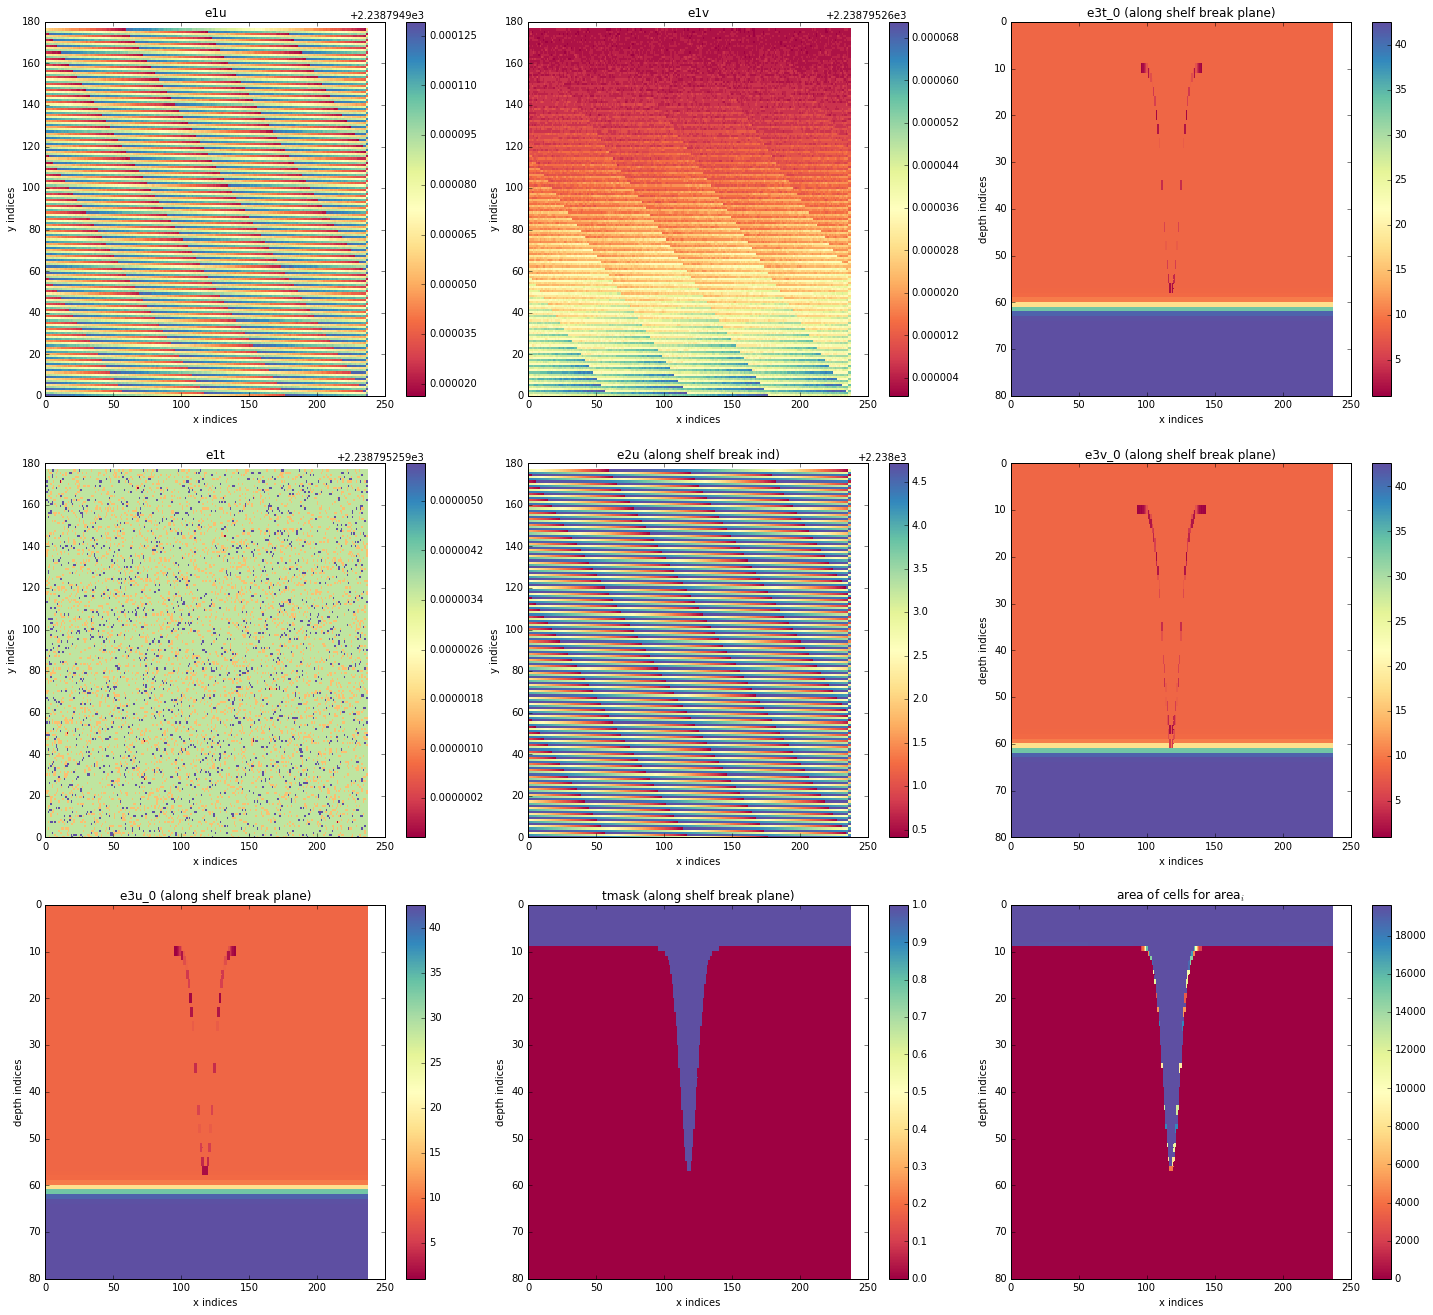

In [63]:
fig, ([ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9]) = plt.subplots(3,3, figsize=(20,18))
plt.tight_layout(h_pad=5, w_pad=3)
ax3.set_title('e3t_0 (along shelf break plane)')
ax3.set_ylabel('depth indices'); ax3.set_xlabel('x indices')
ax1.set_title('e1u')
ax1.set_ylabel('y indices'); ax1.set_xlabel('x indices')
ax2.set_title('e1v')
ax2.set_ylabel('y indices'); ax2.set_xlabel('x indices')
ax8.set_title('tmask (along shelf break plane)')
ax8.set_ylabel('depth indices'); ax8.set_xlabel('x indices')
ax4.set_title('e1t')
ax4.set_ylabel('y indices'); ax4.set_xlabel('x indices')
ax5.set_title('e2u (along shelf break ind)')
ax5.set_ylabel('y indices'); ax5.set_xlabel('x indices')
ax7.set_title('e3u_0 (along shelf break plane)')
ax7.set_ylabel('depth indices'); ax7.set_xlabel('x indices')
ax6.set_title('e3v_0 (along shelf break plane)')
ax6.set_ylabel('depth indices'); ax6.set_xlabel('x indices')
ax9.set_title('area of cells for area$_i$')
ax9.set_ylabel('depth indices'); ax9.set_xlabel('x indices')

p = ax1.pcolor(e1u[:,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax1)

p = ax2.pcolor(e1v[:,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax2)

p3 = ax3.pcolor(e3t_0[:,ind_plane,:], cmap=cm.Spectral)
fig.colorbar(p3, ax=ax3)
ax3.invert_yaxis()

p = ax4.pcolor(e1t[:,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax4)

p = ax5.pcolor(e2u, cmap=cm.Spectral)
fig.colorbar(p, ax=ax5)

p = ax6.pcolor(e3v_0[:,ind_plane,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax6)
ax6.invert_yaxis()

p = ax7.pcolor(e3u_0[:,ind_plane,:], cmap=cm.Spectral)
fig.colorbar(p, ax=ax7)
ax7.invert_yaxis()

p = ax8.pcolor(mask_plane, cmap=cm.Spectral)
fig.colorbar(p, ax=ax8)
ax8.invert_yaxis()

p = ax9.pcolor(area_i, cmap=cm.Spectral)
fig.colorbar(p, ax=ax9)
ax9.invert_yaxis()

# Horizontal Plane

In [13]:
this_area = area_j

area_all = np.zeros(this_area.shape[0])
for depth_ind in range(this_area.shape[0]):
    area_row = this_area[depth_ind,:].sum()
    area_all[depth_ind] = area_row
    
area_canyon = area_all[ind_shelf:ind_canyon]
area_canyon_inds = np.arange(ind_shelf,ind_canyon)

In [14]:
total_area_canyon = np.sum(area_canyon)
half_area_canyon = total_area_canyon / 2
cumsum_area_canyon = np.cumsum(area_canyon)
half_area_canyon_ind = (np.abs(cumsum_area_canyon-half_area_canyon)).argmin()
half_area_ind = area_canyon_inds[half_area_canyon_ind]
depth_half = gdepw_1d[half_area_ind]

In [15]:
sum_area_plane = np.sum(area_all)
sum_area_over_break = np.sum(area_all[:ind_shelf])
sum_area_top_half = np.sum(area_all[ind_shelf:half_area_ind+1])
sum_area_bot_half = np.sum(area_all[half_area_ind+1:])

total area on plane: 56426475.2774
area above break depth: 41761084.5848
area in top half: 7475798.10116
area in bottom half: 7189592.59145


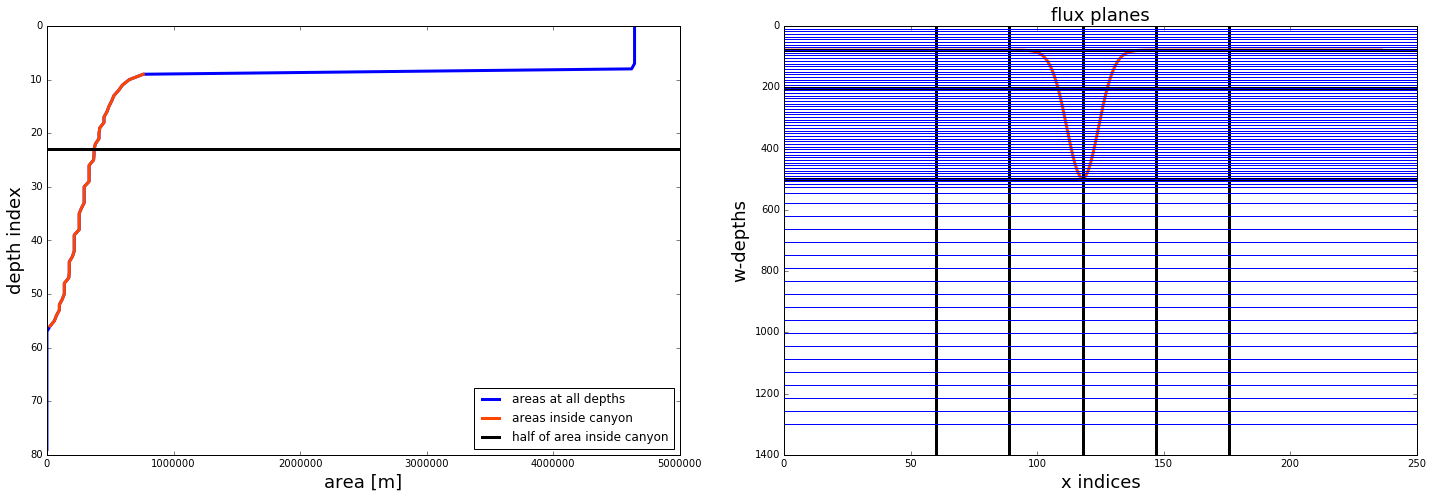

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
ax1.plot(area_all, np.arange(this_area.shape[0]), c='b', lw=3, label='areas at all depths')
ax1.plot(area_canyon, area_canyon_inds, c='orangered', lw=3, label='areas inside canyon')
ax1.axhline(half_area_ind, c='k', lw=3, label='half of area inside canyon')
ax1.invert_yaxis(); ax1.legend(loc=4)
ax1.set_ylabel('depth index', fontsize=18)
ax1.set_xlabel('area [m]', fontsize=18)

print('total area on plane:', sum_area_plane)
print('area above break depth:', sum_area_over_break)
print('area in top half:', sum_area_top_half)
print('area in bottom half:', sum_area_bot_half)

ax2.plot(bathy_plane, lw=3, c='orangered')
ax2.invert_yaxis()
ax2.axhline(depth_shelf, c=c, lw=lw)
ax2.axhline(depth_canyon, c=c, lw=lw)
ax2.axhline(depth_half, c=c, lw=lw)
ax2.axvline(ind_axis, c=c, lw=lw)
ax2.axvline(ind_rimL, c=c, lw=lw)
ax2.axvline(ind_rimR, c=c, lw=lw)
ax2.axvline(ind_shfL, c=c, lw=lw)
ax2.axvline(ind_shfR, c=c, lw=lw)
for gdepw in zip(gdepw_1d):
    ax2.axhline(gdepw, c='b', label = 'gdepw')
ax2.set_title('flux planes', fontsize=18)
ax2.set_ylabel('w-depths', fontsize=18)
ax2.set_xlabel('x indices', fontsize=18)
    
plt.tight_layout(h_pad=5, w_pad=3)

# Flux Basic
# $Q_j = v \times e1v \times e3v$

## and

# $Q_i = u \times e2u \times e3u$

In [82]:
time_ind = 200
u = U_masked[time_ind,:,ind_plane,:]
Qi = u * area_i

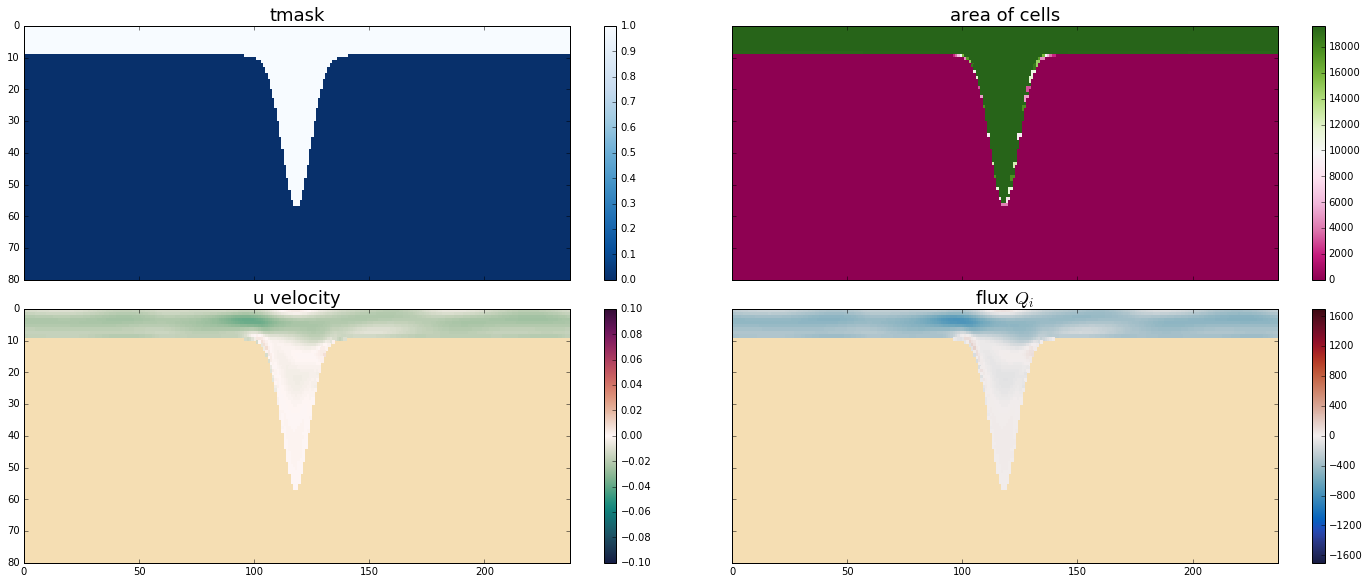

In [91]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2,figsize=(20,8), sharey=True, sharex=True)
plt.tight_layout(h_pad=2, w_pad=1)

p = ax1.pcolor(mask_plane, cmap=cm.Blues_r)
fig.colorbar(p, ax=ax1)
ax1.set_title('tmask', fontsize=18)

p = ax2.pcolor(area_i, cmap=cm.PiYG)
fig.colorbar(p, ax=ax2)
ax2.set_title('area of cells', fontsize=18)

p = ax3.pcolor(u, vmin=-0.1, vmax=0.1, cmap=cmo.cm.curl)
fig.colorbar(p, ax=ax3)
ax3.set_title('u velocity', fontsize=18)
ax3.set_axis_bgcolor('wheat')

p = ax4.pcolor(Qi, vmin=-1700, vmax=1700, cmap=cmo.cm.balance)
fig.colorbar(p, ax=ax4)
ax4.set_title('flux $Q_i$', fontsize=18)
ax4.set_axis_bgcolor('wheat')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim([mask_plane.shape[0], 0])
    ax.set_xlim([0, mask_plane.shape[1]])

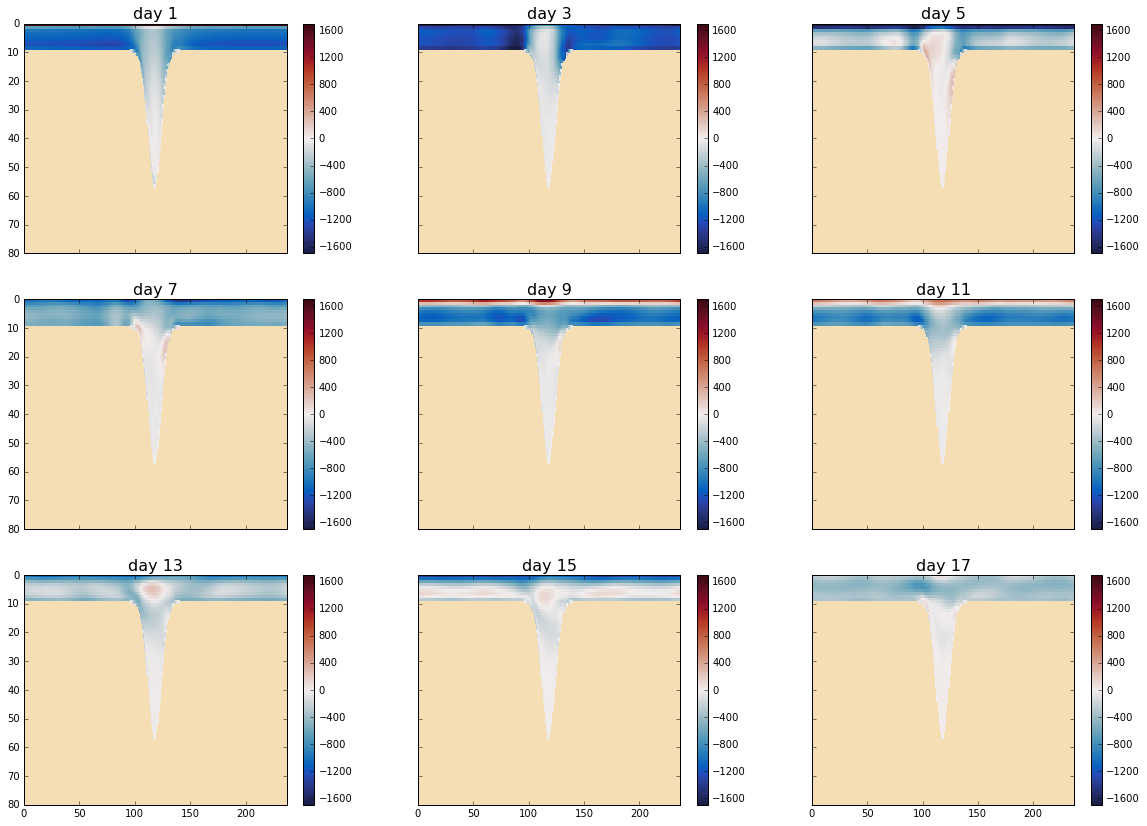

In [90]:
fig, ax = plt.subplots(3,3,figsize=(20, 14), sharex=True, sharey=True)
ax = ax.flatten()
time_inds = np.arange(1,18,2)*24
for n, time_ind in zip(np.arange(12), time_inds):
    u = U_masked[time_ind,:,ind_plane,:]
    Qi = u * area_i
    p = ax[n].pcolor(Qi, vmin=-1700, vmax=1700, cmap=cmo.cm.balance)
    fig.colorbar(p, ax=ax[n])
    ax[n].set_axis_bgcolor('wheat')
    ax[n].set_title('day '+str(int(time_ind/24)), fontsize=16)
    ax[n].set_ylim([Qi.shape[0], 0])
    ax[n].set_xlim([0, Qi.shape[1]])

# Flux Through Planes

In [109]:
time_ind = 48
u = U_masked[time_ind,:,ind_plane,:]
Qi = u * area_i

Qi.shape

(80, 237)

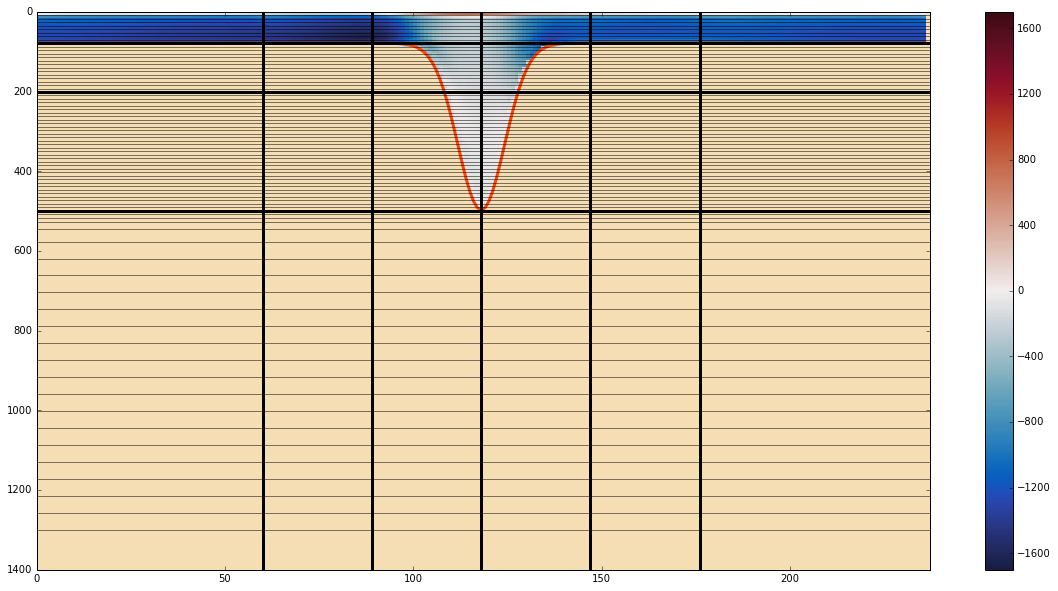

In [110]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(bathy_plane, lw=3, c='orangered')
#ax.axhline(depth_shelf, c=c, lw=lw)
#ax.axhline(depth_canyon, c=c, lw=lw)
#ax.axhline(depth_half, c=c, lw=lw)
ax.axvline(ind_axis, c=c, lw=lw)
ax.axvline(ind_rimL, c=c, lw=lw)
ax.axvline(ind_rimR, c=c, lw=lw)
ax.axvline(ind_shfL, c=c, lw=lw)
ax.axvline(ind_shfR, c=c, lw=lw)
for gdepw in zip(gdepw_1d):
    ax.axhline(gdepw, c='k', alpha=0.5)
    
p = ax.pcolor(np.arange(Qi.shape[1]), gdepw_1d, Qi, vmin=-1700, vmax=1700, cmap=cmo.cm.balance)
fig.colorbar(p, ax=ax)
ax.set_axis_bgcolor('wheat')
ax.set_xlim([0, Qi.shape[1]])
ax.invert_yaxis()

* sum_area_plane = np.sum(area_all)
* sum_area_over_break = np.sum(area_all[:ind_shelf])
* sum_area_top_half = np.sum(area_all[ind_shelf:half_area_ind+1])
* sum_area_bot_half = np.sum(area_all[half_area_ind+1:])